In [1]:
import os
import glob
import pickle
import gzip
import numpy as np
import pandas as pd

import tensorflow as tf
#tf.enable_eager_execution()

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from matplotlib import pyplot as plt
%matplotlib inline
from werdich_cfr.tfutils.TFRprovider import DatasetProvider
from werdich_cfr.tfutils.Modeltrainer import VideoTrainer
from werdich_cfr.utils.visuals import ImageSliceViewer3D

TensorFlow Version: 2.1.0


### Recover data from TFRecords: look at the postprocessed images ###

In [2]:
# Directories and files
cfr_data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
meta_date = '200227'
tfr_dir = os.path.join(cfr_data_root, 'tfr_'+meta_date)
meta_dir = os.path.join(cfr_data_root, 'metadata_'+meta_date)

# TFR file
tfr_file = os.path.join(tfr_dir, 'cfr_resized_a4c_train_200227_0.tfrecords')
parquet_file = os.path.join(tfr_dir, 'cfr_resized_a4c_train_200227_0.parquet')

# Load df 
df = pd.read_parquet(parquet_file)
df.head(50)

,study,mrn,echo_study_date,mrnstudyid,days_post_cfr,cfr_study_date,petmrn_identifier,post-2018,myocardial_perfusion,global_cfr_calc,unaffected_cfr,rest_mbf_unaff,stress_mbf_unaff,num_unaffected_segs,rest_global_mbf,stress_global_mbf,filename,dir,datetime,fileid,institution,model,manufacturer,index,frame_time,number_of_frames,heart_rate,deltaX,deltaY,a2c,a2c_laocc,a2c_lvocc_s,a3c,a3c_laocc,a3c_lvocc_s,a4c,a4c_far,a4c_laocc,a4c_lvocc_s,a4c_rv,a4c_rv_laocc,a5c,apex,other,plax_far,plax_lac,plax_laz,plax_laz_ao,plax_plax,psax_avz,psax_az,psax_mv,psax_pap,rvinf,subcostal,suprasternal,max_view,mode,rate,im_array_shape
59658,4a175a199d2cd107_4903a58dd542e4ec350015a4783c,11910056,2018-01-25,1010,-28,2018-02-22,11910056_2018-02-22,0,abnormal,2.427019,2.526140,0.658575,1.663653,5,0.644,1.563,4a175a199d2cd107_4903a58dd542e4ec350015a4783c_...,/mnt/obi0/phi/echo/npyFiles/BWH/4a17/4a175a199...,2018-01-25 08:31:53,4a175a199d2cd107_4903a58dd542e4ec350015a4783c_...,BWH,Vivid E95,GE Vingmed Ultrasound,0.0,28.724490,99.0,65.0,0.027251,0.027251,2.586766e-14,9.132845e-14,4.388857e-13,5.841986e-15,4.956273e-14,2.391064e-13,0.999999,1.021317e-06,4.229681e-14,2.260299e-15,1.480851e-12,1.099412e-14,1.634575e-12,2.097466e-14,3.928139e-17,9.893973e-16,1.762716e-14,1.599810e-13,4.084227e-14,1.323253e-15,2.378096e-10,3.567024e-14,6.189622e-13,2.506569e-09,1.072428e-13,5.220740e-17,8.830496e-13,a4c,train,34.8,"[193, 277, 40]"
27040,490b13fe1869fe6f_4903a58dd5465400b623f4792e3c,28944601,2018-05-25,2500,-139,2018-10-11,28944601_2018-10-11,1,normal,1.760000,1.760000,0.490000,0.860000,17,0.490,0.860,490b13fe1869fe6f_4903a58dd5465400b623f4792e3c_...,/mnt/obi0/phi/echo/npyFiles/BWH/490b/490b13fe1...,2018-05-25 10:37:44,490b13fe1869fe6f_4903a58dd5465400b623f4792e3c_...,BWH,iE33,Philips Medical Systems,0.0,33.333000,79.0,61.0,0.044038,0.044038,5.427806e-09,7.937334e-14,5.352992e-12,1.840808e-08,5.120532e-12,1.646321e-11,1.000000,3.562050e-11,1.577377e-10,2.556859e-12,8.260823e-08,1.153989e-11,5.650925e-11,1.414440e-10,9.854296e-13,1.274652e-12,5.407619e-11,2.100804e-13,8.005013e-12,4.613763e-10,1.137898e-08,2.941360e-12,1.255399e-11,3.202612e-08,4.409241e-09,2.236418e-13,1.864441e-11,a4c,train,30.0,"[264, 352, 40]"
9803,4b7a873e7521860a_4903a583583e2c4f6357119c4aa0,1088541,2016-09-12,60,-4,2016-09-16,1088541_2016-09-16,0,normal,1.592339,1.588150,0.727706,1.155706,17,0.731,1.164,4b7a873e7521860a_4903a583583e2c4f6357119c4aa0_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b7a/4b7a873e7...,2016-09-12 13:27:34,4b7a873e7521860a_4903a583583e2c4f6357119c4aa0_...,BWH,iE33,Philips Medical Systems,0.0,33.333000,76.0,74.0,0.048411,0.048411,4.065062e-08,1.616387e-06,2.080527e-08,4.034011e-12,4.060193e-09,2.087222e-07,0.999605,2.310929e-04,4.321074e-12,6.329066e-09,1.568749e-04,9.220278e-10,2.638234e-07,2.469210e-10,9.262556e-08,1.846407e-06,1.905241e-07,1.623496e-07,2.188078e-11,3.850326e-07,1.286353e-06,6.421823e-07,4.002285e-07,1.888709e-09,2.509202e-09,5.183403e-11,1.309894e-08,a4c,train,30.0,"[290, 387, 40]"
54012,4b735bf2c4a1610e_4903a44b3308918122647e14866e,8273492,2008-12-02,725,-93,2009-03-05,8273492_2009-03-05,0,normal,2.080460,2.065563,1.741471,3.597118,17,1.740,3.620,4b735bf2c4a1610e_4903a44b3308918122647e14866e_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b73/4b735bf2c...,2008-12-02 11:13:48,4b735bf2c4a1610e_4903a44b3308918122647e14866e_...,BWH,iE33,Philips Medical Systems,0.0,33.333000,91.0,90.0,0.037483,0.037483,3.765931e-04,7.140780e-09,3.809059e-11,3.812993e-10,3.625203e-07,3.003027e-09,0.999455,1.679200e-10,1.977190e-13,6.522366e-11,4.903225e-07,5.608397e-11,1.668913e-04,1.058663e-08,9.237421e-09,1.088846e-10,2.995970e-07,3.206745e-09,1.138073e-11,6.013839e-09,1.065605e-10,2.006487e-14,6.517859e-09,3.871434e-11,9.830636e-12,1.835230e-09,3.571924e-11,a4c,train,30.0,"[225, 300, 40]"
24994,4a14fc320218f426_4903a581a6812095fb5633e99e4f,12678751,2014-10-20,1071,349,2013-11-05,12678751_2013-11-05,0,abnormal,1.692509,1.733512,1.160778,2.012222,9,1.148,1.943,4a14fc320218f426_4903a581a68

### Percentile thresholds for classification and image sizes ###

In [3]:
# TFR .parquet data files
train_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized_a4c_train_200227_*.parquet'))
eval_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized_a4c_eval_200227_*.parquet'))
test_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized_a4c_test_200227_*.parquet'))

train_df = pd.concat([pd.read_parquet(file) for file in train_files])
eval_df = pd.concat([pd.read_parquet(file) for file in eval_files])
test_df = pd.concat([pd.read_parquet(file) for file in test_files])
dset = pd.concat([train_df, eval_df, test_df], axis = 0, ignore_index=True).reset_index(drop=True)
print(dset.shape)

(606, 60)


In [4]:
print('Size of cfr table:', dset.shape)
cfr_array = dset.unaffected_cfr.values
p_list = [np.round(np.percentile(cfr_array, p), decimals = 3) for p in (25, 50, 75)]
print('Percentile boundaries:', p_list)

Size of cfr table: (606, 60)
Percentile boundaries: [1.377, 1.69, 2.208]


In [5]:
percentile_list = p_list
def cfr_p_label(cfr_value):
    return np.digitize(cfr_value, bins = percentile_list)
# Setting the threshold, check the number of positives and negatives
df['labelp'] = df['unaffected_cfr'].apply(cfr_p_label)
print(df.labelp.iloc[0:10].values)

[3 2 1 2 2 1 1 0 2 2]


In [6]:
def cfr_label(cfr_value):
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    
    for p in range(1, len(percentile_list)):
        
        if (cfr_value >= percentile_list[p-1]) & (cfr_value < percentile_list[p]):
            label = p
    
    return label

df['label'] = df['unaffected_cfr'].apply(cfr_label)
print(df.label.iloc[0:10].values)

[3 2 1 2 2 1 1 0 2 2]


In [7]:
label_list = sorted(df.label.unique())
print('Unique labels:', label_list)
df.head(20)
# Number of samples in each group
samples = [df[df.label == l].shape[0] for l in label_list]
for l in label_list:
    print('Label:', l, 'samples:', samples[l])

Unique labels: [0, 1, 2, 3]
Label: 0 samples: 41
Label: 1 samples: 40
Label: 2 samples: 35
Label: 3 samples: 28


### TFR extraction and postprocessing ###

In [9]:
n_frames=40
cfr_boundaries=(1.232, 1.556, 2.05)
output_height=299
output_width=299
#im_scale_factor=0.5642
im_scale_factor=0.849
record_output=False
batch_size=8

In [10]:
@tf.function
def cfr_label(cfr_value):
    ''' classification label for cfr value '''
    percentile_list = cfr_boundaries
    label = 0
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    for p in range(1, len(percentile_list)):
        if (cfr_value >= percentile_list[p - 1]) & (cfr_value < percentile_list[p]):
            label = p
    return tf.one_hot(label, depth = len(percentile_list)+1)

In [15]:
def parse(serialized):

    example = {'image': tf.io.FixedLenFeature([], tf.string),
               'shape': tf.io.FixedLenFeature([], tf.string),
               'cfr': tf.io.FixedLenFeature([], tf.float32),
               'rest_mbf': tf.io.FixedLenFeature([], tf.float32),
               'stress_mbf': tf.io.FixedLenFeature([], tf.float32),
               'record': tf.io.FixedLenFeature([], tf.int64)}

    # Extract example from the data record
    example = tf.io.parse_single_example(serialized, example)

    # Convert image to tensor and shape it
    image_raw = tf.io.decode_raw(example['image'], tf.uint16)
    shape = tf.io.decode_raw(example['shape'], tf.uint16)
    shape = tf.cast(shape, tf.int32) # tf.reshape requires int16 or int32 types
    image = tf.reshape(image_raw, shape)

    # Here, we have recovered the original shape of the images.
    # Now we need to process them.

    cfr = example['cfr']
    rest_mbf = example['rest_mbf']
    stress_mbf = example['stress_mbf']
    record = example['record']

    # categorical and regression outputs (tuple of dicts)

    if not record_output:
        # For training, use only model input/outputs
        outputs = ({'video': process_image(image, shape)},
                   {'class_output': cfr_label(cfr),
                    'score_output': cfr,
                    'mbf_output': rest_mbf})
    else:
        outputs = ({'video': process_image(image, shape)},
                   {'class_output': cfr_label(cfr),
                    'score_output': cfr,
                    'mbf_output': rest_mbf},
                   {'record': record})

    return outputs

In [16]:
def process_image(image, shape):

    # original shape is [height, width, frames] -> [frames, height, width, 1]
    # If there is no scale-factor, the images will be resized to fit
    image = tf.reshape(image, shape=shape)
    image = tf.transpose(image, perm=[2, 0, 1])
    image = tf.expand_dims(image, axis=-1)

    if im_scale_factor is None:
        image = tf.image.resize_with_pad(image,
                                         target_height=output_height,
                                         target_width=output_width)
    else:
        # Re-size the image with a single scale factor, then pad to output_size
        im_size = tf.cast(tf.slice(shape, [0], [2]), dtype=tf.float32)
        new_im_size = tf.cast(tf.math.ceil(tf.math.scalar_mul(im_scale_factor, im_size)), tf.int32)
        image = tf.image.resize(image, size=new_im_size, antialias=True)
        # Crop or pad to the output size
        image = tf.image.resize_with_crop_or_pad(image,
                                                 target_height=output_height,
                                                 target_width=output_width)

    # Scale image to have mean 0 and variance 1
    #image = tf.cast(image, tf.float64)
    image = tf.cast(image, tf.float32)
    image = tf.image.adjust_contrast(image, contrast_factor=5)
    output_image = tf.image.per_image_standardization(image)

    return output_image

In [17]:
dataset = tf.data.TFRecordDataset([tfr_file])
        
# Parse records
dataset = dataset.map(map_func=parse, num_parallel_calls = None)

# Batch it up
dataset = dataset.batch(batch_size, drop_remainder=True)

# Prefetch
#dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset = dataset.repeat(count=1)

In [18]:
for out in dataset.take(1):
    output = out

# Output batch is a list of dictionaries [INPUT, OUTPUT]:
print('Input keys: ', output[0].keys())
print('Output keys:', output[1].keys())
image_batch = output[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)
class_label_batch = output[1]['class_output'].numpy()
print('Class batch output shape:', class_label_batch.shape)
cfr_batch = output[1]['score_output'].numpy()
mbf_batch = output[1]['mbf_output'].numpy()
print('CFR batch output shape:', cfr_batch.shape)

Input keys:  dict_keys(['video'])
Output keys: dict_keys(['class_output', 'score_output', 'mbf_output'])
Video batch shape: (8, 40, 299, 299, 1)
Class batch output shape: (8, 4)
CFR batch output shape: (8,)


In [19]:
print(mbf_batch)

[0.658575   0.49       0.7277059  1.7414706  1.1607778  0.6295
 0.91641176 1.4010909 ]


In [20]:
print(df.rest_mbf_unaff.iloc[:batch_size])

59658    0.658575
27040    0.490000
9803     0.727706
54012    1.741471
24994    1.160778
98617    0.629500
21794    0.916412
44749    1.401091
Name: rest_mbf_unaff, dtype: float64


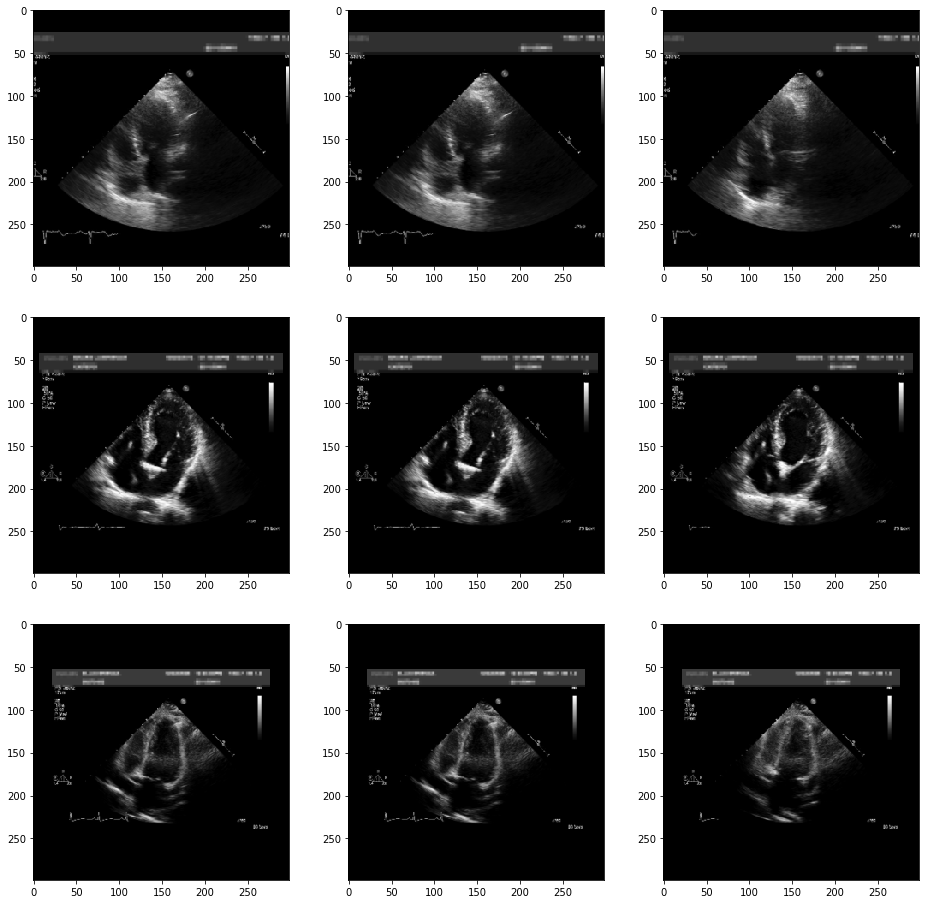

In [21]:
# Show some images from the batch
sample_idx = np.random.randint(batch_size, size=3)
frame_idx = np.random.randint(n_frames, size=3)

fig, ax = plt.subplots(nrows=len(sample_idx), ncols=len(frame_idx), figsize = (16,16))

for row, sample in enumerate(sample_idx):
    for col, frame in enumerate(frame_idx):
        image = np.squeeze(image_batch[sample, frame, :, :, 0])
        ax[row, col].imshow(image, cmap = 'gray')